In [1]:
import os, sys, time
import numpy as np
from numpy import sqrt, exp, pi, square
import pandas as pd
pd.options.mode.chained_assignment = None        # default='warn'
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'   # enable if you have a retina display
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d, UnivariateSpline
import warnings
warnings.filterwarnings('ignore')
from multihist import Histdd, Hist1d
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool
from contextlib import contextmanager

def plt_config(title=None, xlim=None, ylim=None, xlabel=None, ylabel=None, colorbar=False, sci=False, art=plt):
    for field in ['title', 'xlim', 'ylim', 'xlabel', 'ylabel']:
        if eval(field) != None: getattr(art, field)(eval(field))
    if isinstance(sci, str): art.ticklabel_format(style='sci', axis=sci, scilimits=(0,0))
    if isinstance(colorbar,str): art.colorbar(label=colorbar)
    elif colorbar: art.colorbar(label = '$Number\ of\ Entries$')

@contextmanager
def initiate_plot(dimx=24, dimy=9):
    plt.rcParams['figure.figsize'] = (dimx, dimy)
    global fig; fig = plt.figure()
    yield
    plt.show()

In [9]:
import hax
hax.__version__

hax.init(raw_data_access_mode = 'local',
         raw_data_local_path = ['/project/lgrandi/xenon1t/raw_for_waveforms/'], 
         main_data_paths= ['/project2/lgrandi/xenon1t/processed/pax_v6.10.0/',''],
         minitree_paths= ['/project2/lgrandi/zhut/minitrees/pax_v6.10.0',
                          '/project2/lgrandi/xenon1t/minitrees/pax_v6.10.0',
                          '/project2/lgrandi/xenon1t/minitrees/latest'],
         pax_version_policy = 'loose',
         use_rundb=True,
         make_minitree=False,
         minitree_caching=True,)

In [11]:
hax.config['minitree_paths'] = ['/project2/lgrandi/zhut/minitrees/pax_v6.10.0/',
                          '/project2/lgrandi/xenon1t/minitrees/pax_v6.10.0/',
                          '/project2/lgrandi/xenon1t/minitrees/latest/']

In [15]:
from datetime import datetime

import hax
from hax import runs
from hax.minitrees import TreeMaker
from hax.corrections_handler import CorrectionsHandler
from hax.paxroot import loop_over_dataset
from hax.utils import find_file_in_folders, get_user_id
from hax.minitree_formats import get_format

import numpy as np
import pandas as pd
from numpy import sqrt, exp, pi, square

import pickle

class TwoLevelTreeMaker(TreeMaker):
    EventLevelTreeMaker = None

    def __init__(self):
        # Support for string arguments
        if isinstance(self.branch_selection, str):
            self.branch_selection = [self.branch_selection]
        if isinstance(self.extra_branches, str):
            self.extra_branches = [self.extra_branches]

        if not self.branch_selection:
            self.branch_selection = hax.config['basic_branches'] + list(self.extra_branches)
        if 'event_number' not in self.branch_selection:
            self.branch_selection += ['event_number']

        self.cache = dict(peak=[], event=[])
        self.data = dict(peak=[], event=[])

    # Logistic part
    def process_event(self, event):
        result_peaks, result_event = self.extract_data(event)
        if not isinstance(result_peaks, (list, tuple)):
            raise TypeError("MultipleRowExtractor treemakers must extract "
                            "a list of dictionaries, not a %s" % type(result))
        assert len(result_peaks) == 0 or isinstance(result_peaks[0], dict)
        self.cache['peak'].extend(result_peaks)
        self.check_cache(level='peak')

        if not isinstance(result_event, dict):
            raise ValueError("TreeMakers must always extract dictionary")
        self.cache['event'].append(result_event)
        self.check_cache(level='event')

    def get_data(self, dataset, event_list=None):
        """Return data extracted from running over dataset"""
        self.mc_data = runs.is_mc(dataset)[0]
        self.run_name = runs.get_run_name(dataset)
        self.run_number = runs.get_run_number(dataset)
        self.run_start = runs.get_run_start(dataset)
        loop_over_dataset(dataset, self.process_event,
                          event_lists=event_list,
                          branch_selection=self.branch_selection,
                          desc='Making %s minitree' % self.__class__.__name__)

        self.check_cache(level='event', force_empty=True)
        treemaker, already_made, minitree_path = hax.minitrees.check(
            self.run_name, self.EventLevelTreeMaker)
        if not len(self.data['event']):
            log.warning("Not a single row was extracted from dataset %s!" % dataset)
        elif (not already_made) and (event_list == None):    
            metadata_dict = dict(
                version=self.EventLevelTreeMaker.__version__,
                extra=self.EventLevelTreeMaker.extra_metadata,
                pax_version=hax.paxroot.get_metadata(self.run_name)['file_builder_version'],
                hax_version=hax.__version__,
                created_by=get_user_id(),
                event_list=event_list,
                documentation=self.EventLevelTreeMaker.__doc__,
                timestamp=str(
                    datetime.now()))

            get_format(minitree_path, self.EventLevelTreeMaker). \
                save_data(metadata_dict, pd.concat(self.data['event'], ignore_index=True))

        self.check_cache(level='peak', force_empty=True)
        if not len(self.data['peak']):
            log.warning("Not a single row was extracted from dataset %s!" % dataset)
            return pd.DataFrame([], columns=['event_number', 'run_number'])
        else:
            hax.log.debug("Extraction completed, now concatenating data")
            return pd.concat(self.data['peak'], ignore_index=True)

    def check_cache(self, level, force_empty=False):
        if not len(self.cache[level]) or (len(self.cache[level]) < self.cache_size and not force_empty):
            return
        self.data[level].append(pd.DataFrame(self.cache[level]))
        self.cache[level] = []


class MultipleS2Corrections(TreeMaker):
    """
    Provides:
     - s2_multi_peak
     - {cs2\cs2t\cs2b}_multi_peak
     - cs1_multi_peak
     - {x\y}_{tpf\nn}_multi_peak (for approximate FV selection)
    """
    __version__ = '6.0.1'
    pax_version_independent = True

class MultipleS2Peaks(TwoLevelTreeMaker):
    __version__ = '6.0.0'
    extra_branches = ['peaks.*']

    sample_duration = 10 # ns
    drift_time_gate = 1.7e3 # ns 
    drift_velocity_liquid = 0.0001335 # cm / ns

    with open('/project2/lgrandi/zhut/s2_single_classifier_gmix_v6.10.0.pkl', 'rb') as f:
        gmix_pattern=pickle.load(f)
    with open('/project2/lgrandi/zhut/s2_width_classifier_gmix_v6.10.0.pkl', 'rb') as f:
        gmix_width=pickle.load(f)

    corrections_handler = CorrectionsHandler()

    EventLevelTreeMaker = MultipleS2Corrections

    def s2_width_model(z):
        z[z > 0] = -1e3 #Hope this can conter 

        w0 = 229.58  #  309.7/1.349
        coeff = 0.925
        dif_const = 31.73
        v = .1335
        return sqrt(square(w0) - 2 * coeff * dif_const * z / v ** 3) * 1.349
    
    def determine_interaction(self, df):
        df['not_interaction_depth'] = (df['z'] > 0) | (df['z'] < -100)
        
        df['not_interaction_pattern'] = False
        mask = df.goodness_of_fit_tpf > 0
        X = np.log10(df.loc[mask,['area', 'goodness_of_fit_tpf', 's2']])
        df.loc[mask, 'not_interaction_pattern']=np.array(MultipleS2Peaks.gmix_pattern.predict(X), bool)
    
        df['not_interaction_width'] = False
        mask = df.range_50p_area > 0
        X = np.column_stack([np.log10(
            df.loc[mask, 'area']), df.loc[mask, 'range_50p_area'] \
            / MultipleS2Peaks.s2_width_model(df.loc[mask, 'z'])])
        df.loc[mask, 'not_interaction_width'] = np.array(
            MultipleS2Peaks.gmix_width.predict(X), bool)
    
        df['not_interaction'] = np.logical_or(df.not_interaction_pattern,  df.not_interaction_width)
        df['not_interaction'] = np.logical_or(df.not_interaction,  df.not_interaction_depth)
        return df
    
    def correction(self, df, run_number, run_start, mc_data):
        """
        Here load correction maps 
        Use both tpf and nn position to do corrections for S2 peaks
        
        Provides:
         - s2_lifetime_correction
         - s2_xy_{tpf\nn}_correction_{tot\top\bottom}
         - s1_xyz_correction_{tpf_fdc_2d\nn_fdc_3d}
         - carea_{tpf\nn}
        """

        df['s2_lifetime_correction'] = (
            MultipleS2Peaks.corrections_handler.get_electron_lifetime_correction(
                run_number, run_start, df.drift_time, mc_data))

        s2_xy_tpf_correction_tot = np.ones(len(df))
        s2_xy_tpf_correction_top = np.ones(len(df))
        s2_xy_tpf_correction_bottom = np.ones(len(df))
        s2_xy_nn_correction_tot = np.ones(len(df))
        s2_xy_nn_correction_top = np.ones(len(df))
        s2_xy_nn_correction_bottom = np.ones(len(df))
        s1_xyz_correction_tpf_fdc_2d = np.ones(len(df))
        s1_xyz_correction_nn_fdc_3d = np.ones(len(df))

        p_i = 0
        for i, p in df.iterrows():
            s2_xy_tpf_correction_tot[p_i] = (
                MultipleS2Peaks.corrections_handler.get_correction_from_map(
                    "s2_xy_map", run_number, [p.x_tpf, p.y_tpf]))

            s2_xy_tpf_correction_top[p_i] = (
                MultipleS2Peaks.corrections_handler.get_correction_from_map(
                    "s2_xy_map", run_number, [p.x_tpf, p.y_tpf], map_name='map_top'))

            s2_xy_tpf_correction_bottom[p_i] = (
                MultipleS2Peaks.corrections_handler.get_correction_from_map(
                    "s2_xy_map", run_number, [p.x_tpf, p.y_tpf], map_name='map_bottom'))

            s2_xy_nn_correction_tot[p_i] = (
                MultipleS2Peaks.corrections_handler.get_correction_from_map(
                    "s2_xy_map", run_number, [p.x_nn, p.y_nn]))

            s2_xy_nn_correction_top[p_i] = (
                MultipleS2Peaks.corrections_handler.get_correction_from_map(
                    "s2_xy_map", run_number, [p.x_nn, p.y_nn], map_name='map_top'))

            s2_xy_nn_correction_bottom[p_i] = (
                MultipleS2Peaks.corrections_handler.get_correction_from_map(
                    "s2_xy_map", run_number, [p.x_nn, p.y_nn], map_name='map_top'))

            s1_xyz_correction_tpf_fdc_2d[p_i] = (
                1 / MultipleS2Peaks.corrections_handler.get_correction_from_map(
                    "s1_lce_map_tpf_fdc_2d", run_number, [p.x_tpf, p.y_tpf, p.z]))

            s1_xyz_correction_nn_fdc_3d[p_i] = (
                1 / MultipleS2Peaks.corrections_handler.get_correction_from_map(
                    "s1_lce_map_nn_fdc_3d", run_number, [p.x_nn, p.y_nn, p.z]))

            p_i += 1

        df['s2_xy_tpf_correction_tot'] = s2_xy_nn_correction_tot
        df['s2_xy_nn_correction_tot'] = s2_xy_nn_correction_tot

        df['s1_xyz_correction_tpf_fdc_2d'] = s1_xyz_correction_tpf_fdc_2d
        df['s1_xyz_correction_nn_fdc_3d'] = s1_xyz_correction_nn_fdc_3d

        df['carea_tpf'] = df.s2_lifetime_correction * df.s2_xy_nn_correction_tot*df.area
        df['carea_nn'] = df.s2_lifetime_correction * df.s2_xy_nn_correction_tot*df.area

        return df
    
    def summarize_to_event(self, df, event_data):
        """
        Now we can start another minitree generation
        Which can fit into standard minitree
        
        Provides:
         - s2_multi_peak
         - {cs2\cs2t\cs2b}_multi_peak
         - cs1_multi_peak
         - {x\y}_{tpf\nn}_multi_peak (for approximate FV selection)
         - n_multi_peak
        """
        mask = np.logical_not(df.not_interaction)

        if len(df.loc[mask])<1:
            return event_data

        df.loc[mask, 'weighted_s1_xyz_correction_tpf_fdc_2d'] = (
            np.average(df.loc[mask, 's1_xyz_correction_tpf_fdc_2d'],
                weights = df.loc[mask, 'carea_tpf']))
        df.loc[mask, 'weighted_s1_xyz_correction_nn_fdc_3d'] = (
            np.average(df.loc[mask, 's1_xyz_correction_nn_fdc_3d'],
                weights = df.loc[mask, 'carea_tpf']))
        

        event_data['s2_multi_peak'] = np.sum(df.loc[mask, 'area'])
        event_data['cs2_multi_peak'] = np.sum(df.loc[mask, 'carea_nn'])
        event_data['cs2t_multi_peak'] = (
            np.sum(df.loc[mask, 'carea_nn'] * df.loc[mask, 'area_fraction_top']))
        event_data['cs2b_multi_peak'] = (
            np.sum(df.loc[mask, 'carea_nn'] * (1 - df.loc[mask, 'area_fraction_top'])))
        event_data['cs1_multi_peak'] = (
            np.average(df.loc[mask, 's1'] * df.loc[mask, 'weighted_s1_xyz_correction_nn_fdc_3d']))
        
        event_data['x_tpf_multi_peak'] = (
            np.average(df.loc[mask, 'x_tpf'], weights = df.loc[mask, 'carea_tpf']))
        event_data['y_tpf_multi_peak'] = (
            np.average(df.loc[mask, 'y_tpf'], weights = df.loc[mask, 'carea_tpf']))
        event_data['x_nn_multi_peak'] = (
            np.average(df.loc[mask, 'x_nn'], weights = df.loc[mask, 'carea_tpf']))
        event_data['y_nn_multi_peak'] = (
            np.average(df.loc[mask, 'y_nn'], weights = df.loc[mask, 'carea_tpf']))
        event_data['n_multi_peak'] = len(df.loc[mask])
        
        return event_data

    def extract_data(self, event):
        """
        At peak level this take after multirowextractor
        Extract S2 peaks in tpc that area>150 and happen after S1 of interaction[0]
        
        Provides:
         direct_fields (check below)
         not_direct_fields (check below)
         corrected_fields (check )
         s1, s2 of interaction[0]
        """
        event_data = dict(
            run_number = self.run_number,
            event_number = event.event_number)
        
        if not len(event.interactions):
            return [], event_data

        interaction = event.interactions[0]
        s1 = event.peaks[interaction.s1]
        s2 = event.peaks[interaction.s2]
        
        direct_fields = ['area', 'area_fraction_top', 'center_time', 'detector', 'index_of_maximum', 'type']

        not_direct_fields = ['goodness_of_fit_nn', 'goodness_of_fit_tpf',
            'range_50p_area', 'x_nn', 'x_tpf', 'y_nn', 'y_tpf']

        number_peaks = len(event.peaks)
        peak_data = {field: list(np.zeros(number_peaks)) for field in direct_fields+not_direct_fields}

        for peak_i, peak in enumerate(event.peaks):
            
            peak_data['range_50p_area'][peak_i] = list(peak.range_area_decile)[5]

            for rp in peak.reconstructed_positions:
                if rp.algorithm == 'PosRecTopPatternFit':
                    for field in ['x', 'y', 'goodness_of_fit']:
                        peak_data[field+'_tpf'][peak_i] = getattr(rp, field)

                if rp.algorithm == 'PosRecNeuralNet':
                    for field in ['x', 'y', 'goodness_of_fit']:
                        peak_data[field+'_nn'][peak_i] = getattr(rp, field)

            for field in direct_fields:
                peak_data[field][peak_i] = getattr(peak, field)

        peaks = pd.DataFrame(peak_data)
        peaks['event_number'] = int(event.event_number)
        peaks['run_number'] = int(self.run_number)
        peaks['drift_time'] = (peaks.index_of_maximum - s1.index_of_maximum) * MultipleS2Peaks.sample_duration
        peaks['z'] = - MultipleS2Peaks.drift_velocity_liquid * (peaks['drift_time'] - MultipleS2Peaks.drift_time_gate)
        peaks['s2'] = s2.area
        peaks['s1'] = s1.area
        
        peaks = peaks[peaks.eval('(type=="s2") & (detector == "tpc") & (area>150) & (z<0)')]
        if len(peaks) < 1:
            return [], dict()
        
        peaks = self.correction(peaks, self.run_number, self.run_start, self.mc_data)
        #peaks = self.determine_interaction(peaks)

        #event_data = self.summarize_to_event(peaks, event_data)

        return peaks.to_dict('records'), event_data

In [4]:
import os
run_names = [f[:11] for f in os.listdir(hax.config['minitree_paths'][0]) if 'MultipleS2Peaks.root' in f]

In [21]:
df_ms_peaks, _ = hax.minitrees.load_single_dataset(run_names[0], [MultipleS2Peaks])

In [17]:
df_ms_corrections = hax.minitrees.load(run_names[:100], ['Corrections', 'Extended', MultipleS2Corrections],
                                       preselection='(z_3d_nn > -90)& (z_3d_nn < -10) & (x_3d_nn**2+y_3d_nn**2<1600)')

(((0.0137*(cs1/(z_3d_nn*0.000092 + 0.14628) + cs2_bottom/(-0.017*z_3d_nn + 10.628)) < 2457.83*(1 - 4*0.01)) | (0.0137*(cs1/(z_3d_nn*0.000092 + 0.14628) + cs2_bottom/(-0.017*z_3d_nn + 10.628)) > 2457.83*(1 + 4*0.01)))) & ((cs1>3000) | ((cs1<252) & (log(cs2_bottom/cs1)/log(10) > 0.466119*exp(-cs1/47.9903) + 1.31033 -0.000314047*cs1 + 1.33977/cs1)) | (largest_other_s2 > 200) | ((cs1<80) & (run_number<=16639)) | ((250<cs1) & (cs1<375) & (log(cs2_bottom/cs1)/log(10) > 0.822161*exp(-(cs1-207.702)/343.275) + 0.515139)) | ((cs1<500) & (r_3d_nn>47.9)) | ((20<=cs1) & (log(cs2_bottom/cs1)/log(10) < 1.21239 + -0.0016025*cs1 + -1.97495/cs1)) | ((cs1>=375) & (log(cs2_bottom/cs1)/log(10) > 1.02015)) | (s2<200) | ((cs1<20) & (log(cs2_bottom/cs1)/log(10) < 1.08159))) & (((run_number>17580) & (run_number<=17820)) | ((0.0137*(cs1/.1426 + cs2_bottom/11.55) < 56.5) | (0.0137*(cs1/.1426 + cs2_bottom/11.55) > 72.)) | (run_number<=16639)) selection: 270140 rows removed (85.49% passed)
(z_3d_nn > -90)& (z_3d_n

In [18]:
from lax.lichens.sciencerun1 import S2SingleScatter
s2s = S2SingleScatter()
df_ms_corrections = s2s.process(df_ms_corrections)

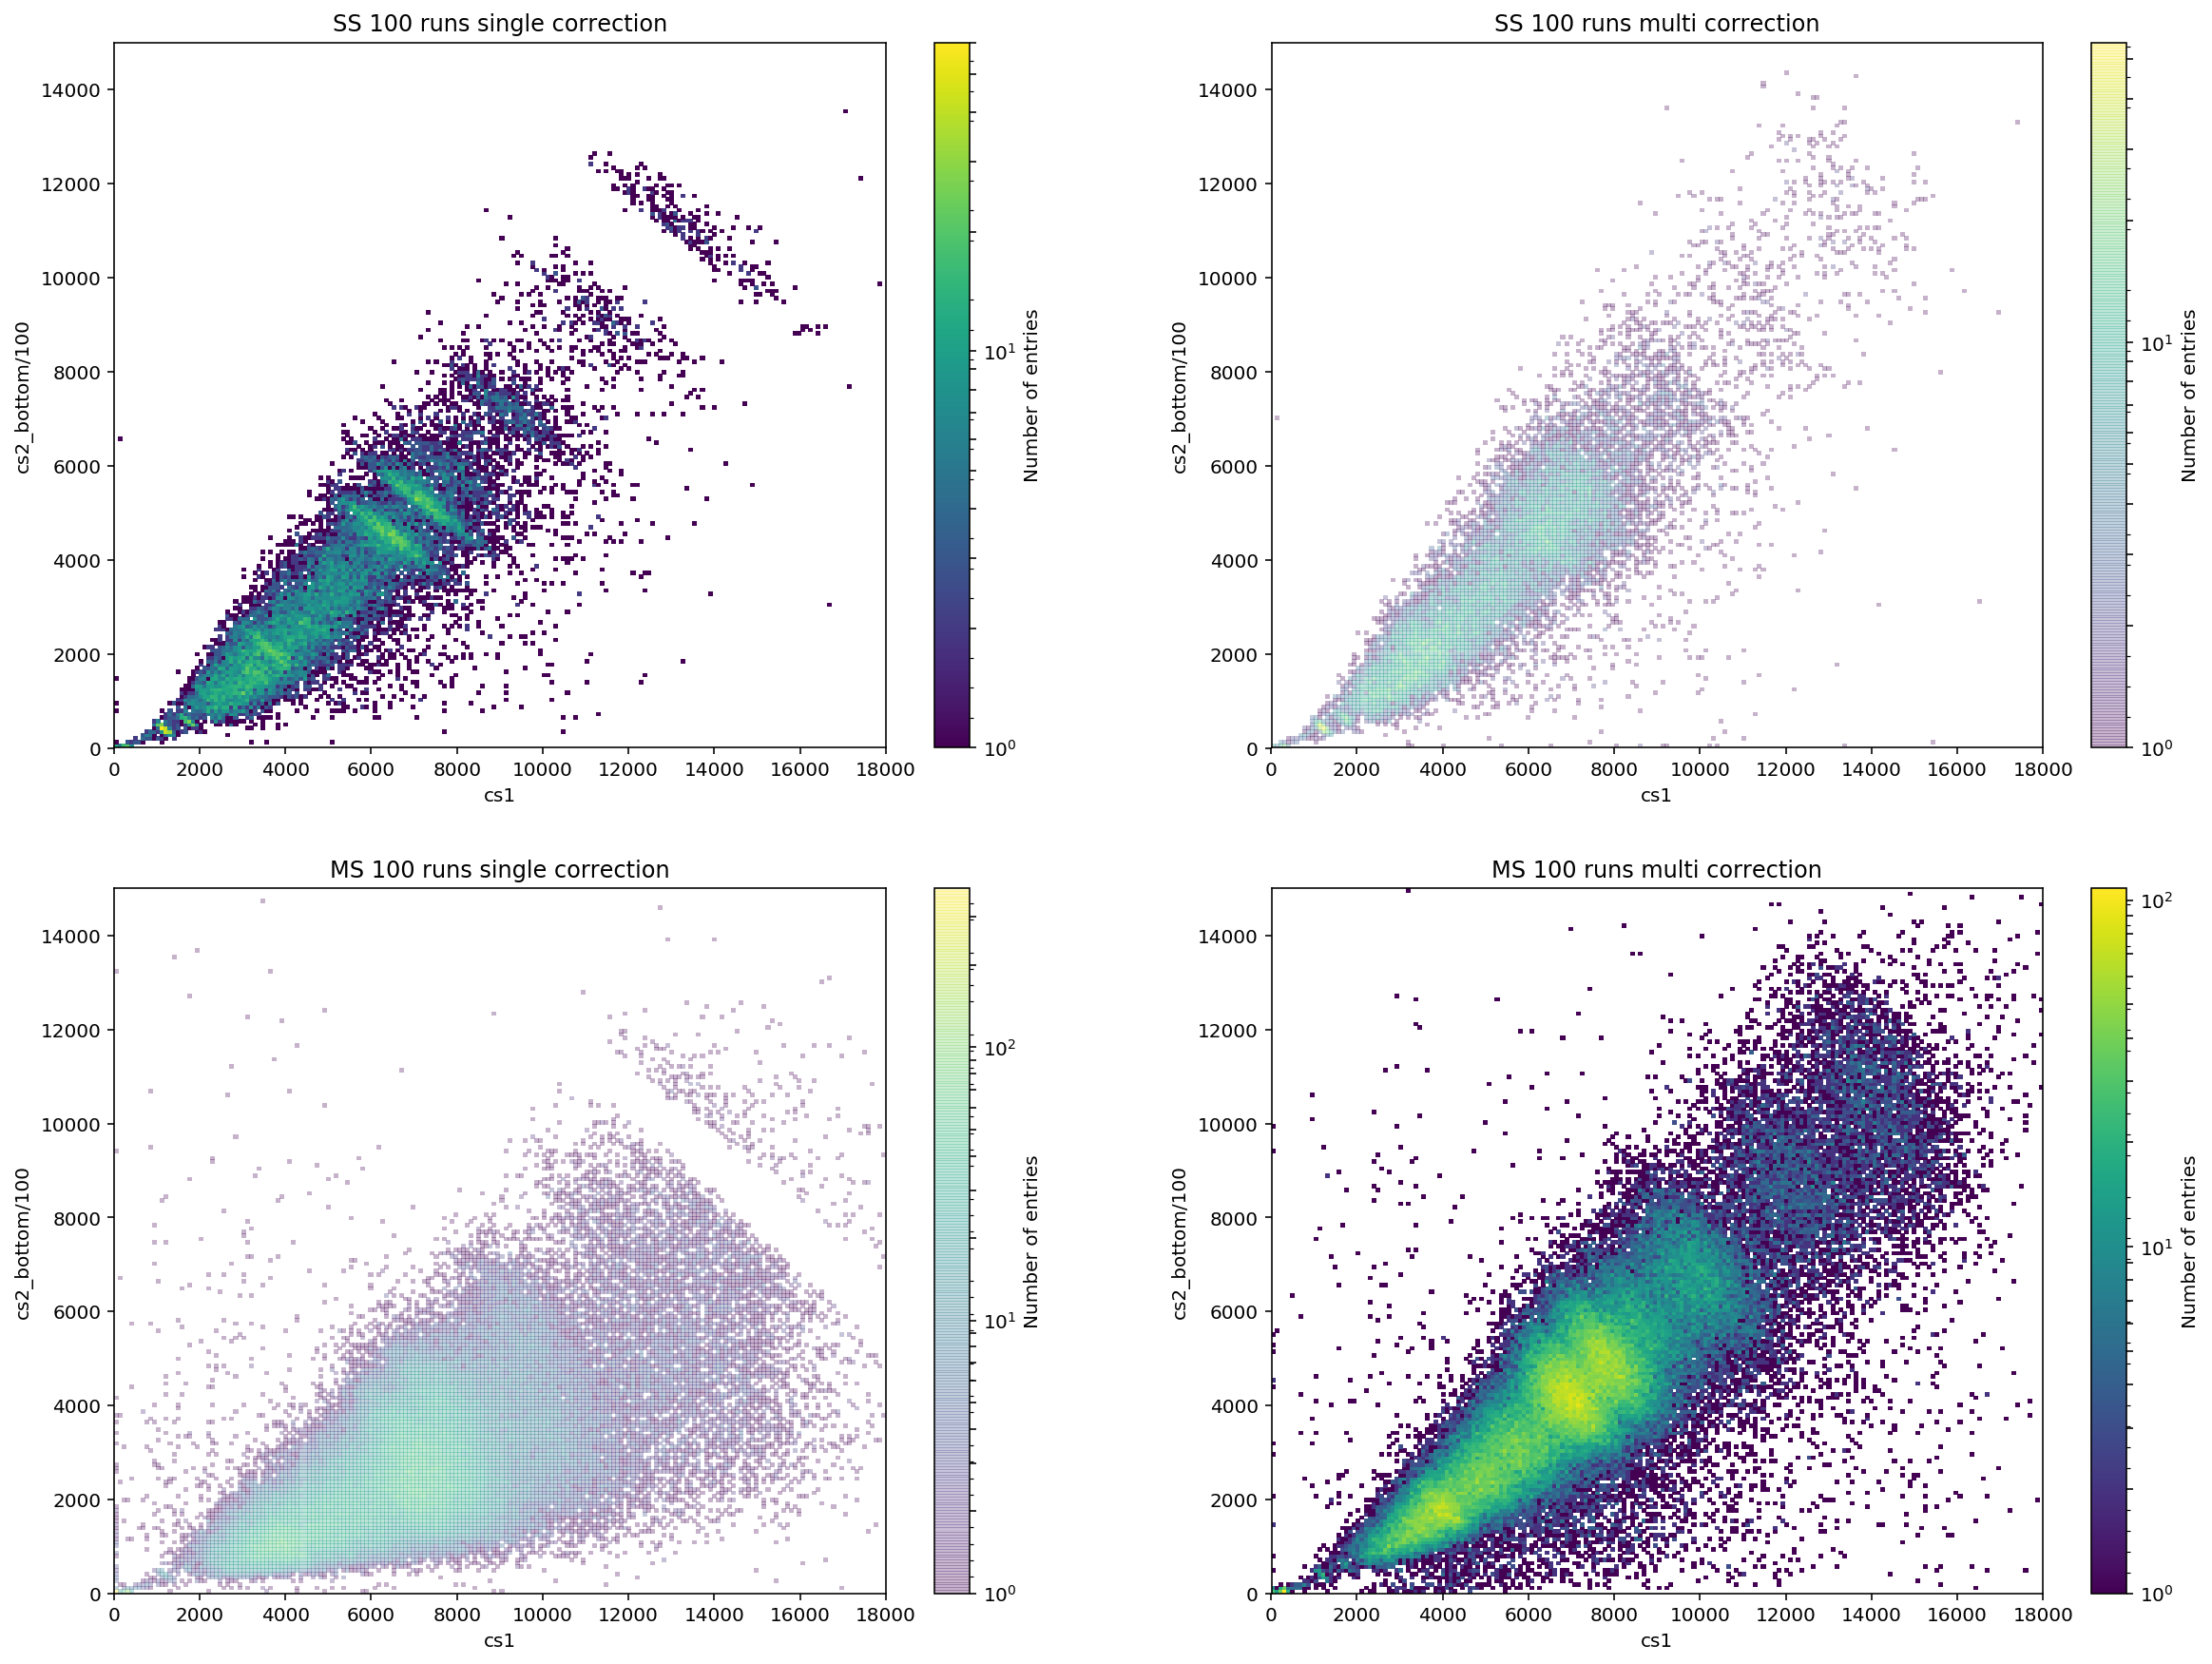

In [19]:
with initiate_plot(20, 15):
    dataframes = ['df_ms_corrections[df_ms_corrections.CutS2SingleScatter]',
                  'df_ms_corrections[df_ms_corrections.CutS2SingleScatter]', 
                  'df_ms_corrections[~df_ms_corrections.CutS2SingleScatter]',
                  'df_ms_corrections[~df_ms_corrections.CutS2SingleScatter]']
    argx = ['{df}.cs1', '{df}.cs1_multi_peak', '{df}.cs1', '{df}.cs1_multi_peak']
    argy = ['{df}.cs2_bottom/100', '{df}.cs2b_multi_peak/100', '{df}.cs2_bottom/100', '{df}.cs2b_multi_peak/100']
    
    titles = ['SS 100 runs single correction', 'SS 100 runs multi correction',
              'MS 100 runs single correction', 'MS 100 runs multi correction']
    alpha = [1, 0.3, 0.3, 1]
    for ix in range(4):
        ax = fig.add_subplot(221+ix)
        mh = Histdd(eval(argx[ix].format(df=dataframes[ix])),
                    eval(argy[ix].format(df=dataframes[ix])),
                    axis_names=['cs1', 'cs2_bottom/100'],
                    bins=[np.linspace(1e1, 1.8e4, 201), np.linspace(1e1, 1.5e4, 201)]
                   )
        mh.plot(log_scale=True, cmap=plt.get_cmap('viridis'), alpha = alpha[ix])
        plt_config(title=titles[ix])
        


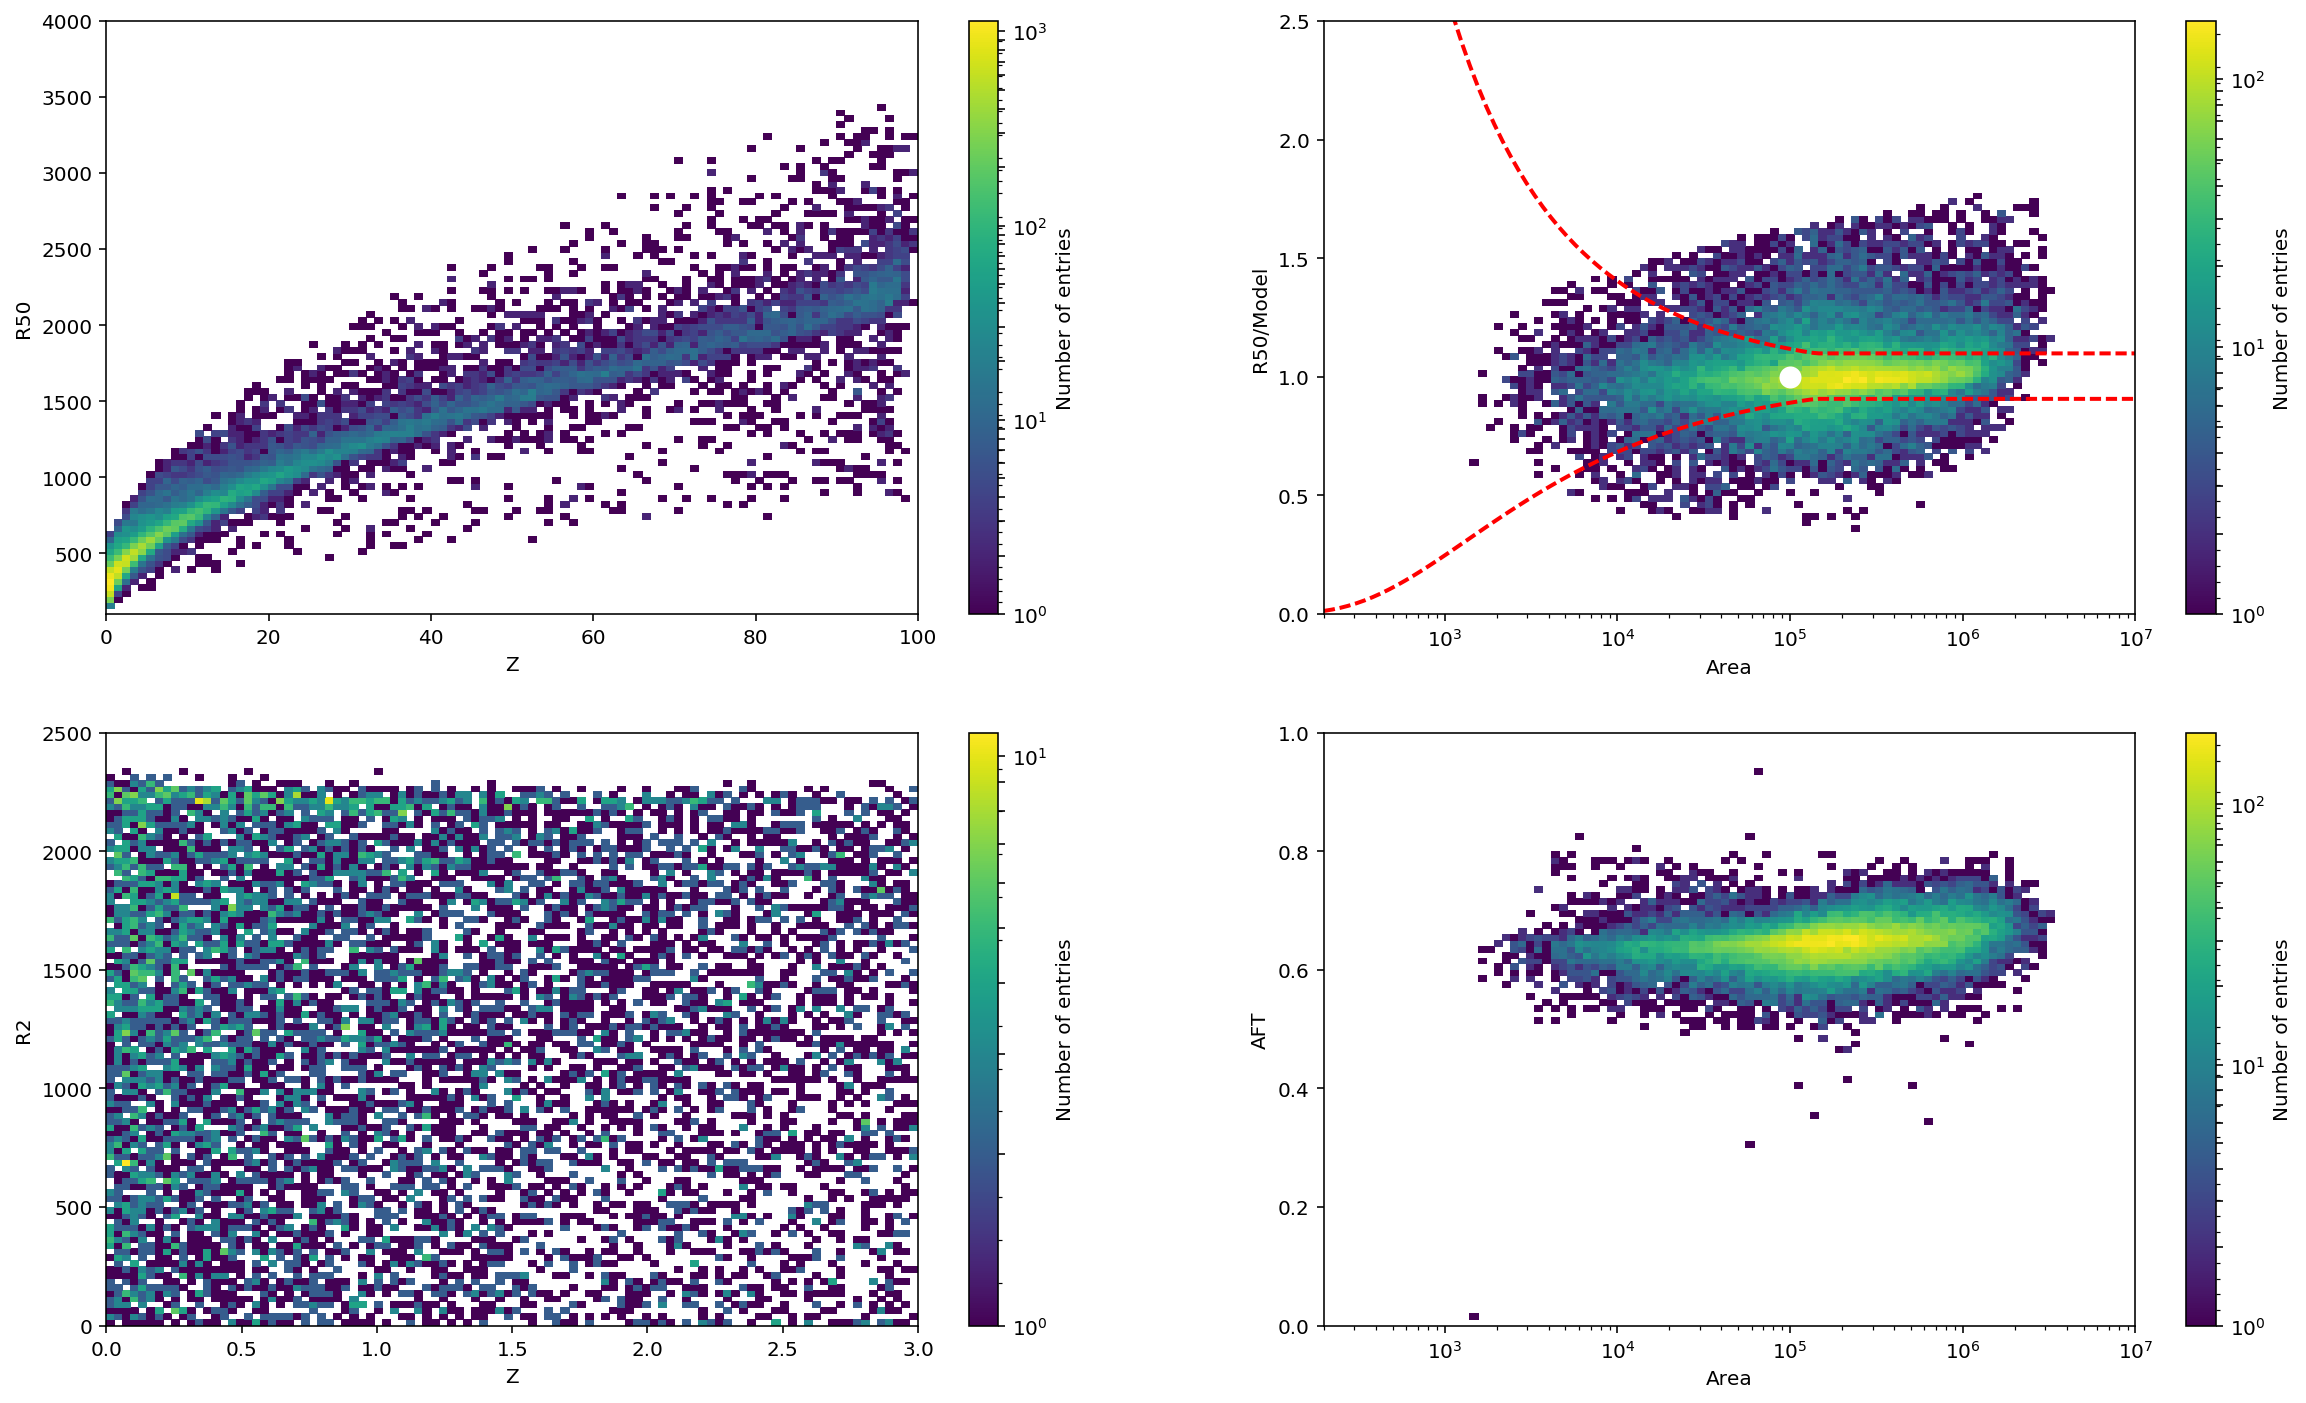

In [23]:
from scipy.stats import chi2
dfs = ['df_ms_peaks[~df_ms_peaks.not_interaction]']

def s2_width_model(z):
    z[z > 0] = -1e3 #Hope this can conter 

    w0 = 229.58  #  309.7/1.349
    coeff = 0.925
    dif_const = 31.73
    v = .1335
    return sqrt(square(w0) - 2 * coeff * dif_const * z / v ** 3) * 1.349

with initiate_plot(20, 12):
    ax = fig.add_subplot(221)
    argx, argy = '-{df}.z', '{df}.range_50p_area'
    mh = Histdd(eval(argx.format(df = dfs[0])), eval(argy.format(df = dfs[0])),
                bins = [np.linspace(0, 100, 101), np.linspace(100, 4000, 101)]
            )
    mh.plot(log_scale = True)
    plt_config(xlabel='Z', ylabel='R50')
    
    
    ax = fig.add_subplot(222)
    argx, argy = '{df}.area', '{df}.range_50p_area/s2_width_model({df}.z)'
    mh = Histdd(eval(argx.format(df = dfs[0])), eval(argy.format(df = dfs[0])),
                bins = [np.logspace(2.3, 7, 101), np.linspace(0, 2.5, 101)]
               )
    mh.plot(log_scale = True)
    plt_config(xlabel='Area', ylabel='R50/Model')
    plt.xscale('log')
    
    means_init = [(10**5, 1), (10**4.3, 1.8), (10**3.9, 0.25)]
    for x, y in means_init:
        plt.scatter(x, y, s=100, color='w')
        
    s2_area_ori = np.logspace(2.3, 7, 101)
    s2_area = np.clip(s2_area_ori, 0, 5000*28)
    logq = -14
    scg = 28
    [plt.plot(s2_area_ori, chi2.ppf(q, df = s2_area/scg)/(s2_area/scg - 1.), color = 'r', ls = '--', lw = 2.0) for q in [np.exp(logq), 1-np.exp(logq)]]

    
    ax = fig.add_subplot(223)
    argx, argy = '-{df}.z', '{df}.x_tpf**2+{df}.y_tpf**2'
    mh = Histdd(eval(argx.format(df = dfs[0])), eval(argy.format(df = dfs[0])),
                bins = [np.linspace(0, 3, 101), np.linspace(0, 2500, 101)]
               )
    mh.plot(log_scale = True)
    plt_config(xlabel='Z', ylabel='R2')

    ax = fig.add_subplot(224)
    argx, argy = '{df}.area', '{df}.area_fraction_top'
    mh = Histdd(eval(argx.format(df = dfs[0])), eval(argy.format(df = dfs[0])),
                bins = [np.logspace(2.3, 7, 101), np.linspace(0, 1, 101)]
            )
    mh.plot(log_scale = True)
    plt.xscale('log')
    plt_config(xlabel='Area', ylabel='AFT')